# Fixed-Step integration of chaotic systems

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lorenz_odeint.ipynb) -->
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lorenz_odeint.ipynb)   


We start by importing the necessary Python packages.


<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [1]:
# Linear algebra libraries
import numpy as np

# Local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Numerical integration

Numerical integration seeks to estimate the solution of differential equations of the form

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})$$

where $\mathbf{y} \in \mathbb{R}^N$ is a vector of $N$ unknown variables describing the state of the system at time $t$.  We will typically discretize time, so that the solution is a sequence of vectors $\mathbf{y}_0, \mathbf{y}_1, \mathbf{y}_2, \ldots$ describing the solution at discrete times $t_0, t_1, t_2, \ldots$. Often we are interested in *initial value problems*, where the initial state $\mathbf{y}(0)$ is known, and we want to find the state $\mathbf{y}(t)$ at later times.

<br><br><br>

### The relationship between integration and optimization

Every optimization problem can be written as an ordinary differential equation (ODE) describing the potential flow $\dot{\mathbf{y}} =  \mathbf{f}(t, \mathbf{y}) = -\nabla U(\mathbf{y}, t)$. However, not every ODE can be written as an optimization problem. Phenomena like limit cycles, chaos, and other interesting phenomena are unique to certain classes of ODEs, but will not occur in optimization problems in standard settings, because potential flows have zero curl.

While we cannot always define a potential function for a given set of ODEs, the gradient and the Hessian are still well-defined. In an ODE context, the gradient is just the right-hand side of the ODE, $\frac{d\mathbf{y}}{dt}$, and the Hessian corresponds to the **Jacobian matrix** of the right-hand side, defined as the matrix of partial derivatives of the right-hand side of the ODE with respect to the unknown variables.

$$
\mathbb{J} = \frac{\partial \dot{\mathbf{y}}}{\partial \mathbf{y}} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} \in \mathbb{R}^{N \times N}
$$

Writing out this Jacobian matrix,
$$
\mathbb{J} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots & \frac{\partial f_1}{\partial y_n} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots & \frac{\partial f_2}{\partial y_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \frac{\partial f_n}{\partial y_2} & \cdots & \frac{\partial f_n}{\partial y_n}
\end{bmatrix}
$$

Just as we in optimization, the right-hand side is always necessary to find the next step in the solution. Knowledge of the Jacobian can improve convergence and stability, as well as reveal mathematical properties of the ODE solution.

<br><br><br>

<!-- $$
\frac{d\mathbf{y}}{dt} = \mathbb{J} \mathbf{y} -->

# The Thomas Model

To demonstrate our numerical integration scheme, we will use a well-known set of coupled ordinary differential equations, the *Thomas model*, given by
$$
    \dot{x} = \sin(y) - b x     \\
    \dot{y} = \sin(z) - b y     \\
    \dot{z} = \sin(x) - b z     \\
$$
These equations describe the motion of a particle confined in a 3D harmonic potential, subject to a periodic lattice of dispersive forces. 

We will frame the problem as an *initial value problem*, where we are given an initial condition $\mathbf{x}(0) \in \mathbb{R}^3$ and aim to find $\mathbf{x}(t) \in \mathbb{R}^3$ for some $t > 0$. 

In [2]:
class ThomasModel:

    def __init__(self, b=0.185):
        self.b = b

    # notice this special method name
    def __call__(self, t, X):
        return self.rhs(t, X)

    def rhs(self, t, X):
        x, y, z = X
        xdot = np.sin(y) - self.b * x
        ydot = np.sin(z) - self.b * y
        zdot = np.sin(x) - self.b * z
        return np.array([xdot, ydot, zdot])

### Implementing the Thomas model

We will implement the Thomas equations as a class, and we set the parameter $b$ is set as an attribute of the class. Since $b$ is a physical property of the system, it will get set as an attribute when we first instantiate the class.

The logic of the differential equations themselves are implemented in the `rhs` method, which takes in a time $t$ and a state vector $\mathbf{X}$ and returns the right-hand side of the ODE, corresponding to the time derivative of the state vector.

We also implement a special method named `__call__`. This is a special method name in Python, and it allows us to use the class as if it were a function.

While we've set up the Thomas model as a class, we haven't yet specified how we want to solve the ODE find the solution to the initial value problem. For now, we'll cheat and use a built-in solver `scipy.integrate.solve_ivp`. This built-in solver has the following signature:

```python
    solve_ivp(rhs, t_span, y0, method='RK45', t_eval=None, **kwargs)
```
where `rhs` is a callable function that returns an array corresponding to the right-hand side of the ODE at a given time $t$ and state $\mathbf{y}$, `t_span` is a tuple of the initial and final times, `y0` is an array of the initial condition, and `method` is the name of the integration method to use. By default, `solve_ivp` uses a Runge-Kutta method, but we can specify a different method if we want. Some Python users might be more familier `scipy.integrate.odeint` instead of `scipy.integrate.solve_ivp`. The latter is a more recent and general suite of solvers.

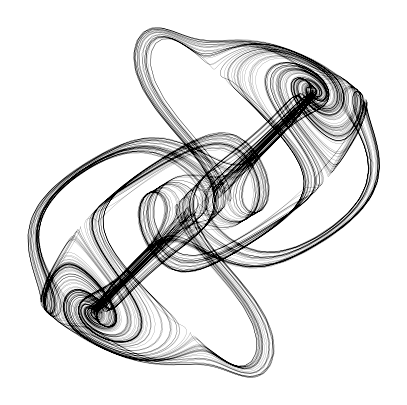

In [3]:
thomas_model = ThomasModel()

# Import the built-in solver scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 6000, 17000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)
plt.axis('off');

We can vary the accuracy of the integration by changing the `rtol` and `atol` parameters. We will learn more about these parameters in a later chapter, but for now, we can think of them as controlling how accurate we want our solution to be. Higher accuracy requires more evaluations of the right-hand side function, and thus more computational time. We will now create an expensive reference trajectory using `solve_ivp` with a more accurate method and smaller tolerances. We will use this reference trajectory to test the accuracy of our implementations of fixed-step integrators.

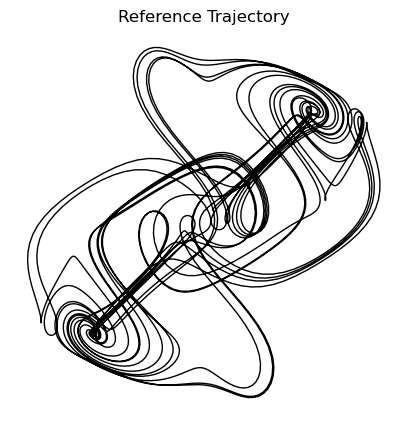

In [4]:
# Let's create an expensive reference trajectory using solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 600, 3000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t, method="Radau", max_step=0.005, rtol=1e-8,  atol=1e-16)
X_reference = sol.y.T.copy()
t_reference = sol.t.copy()


plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=1, color='k')
plt.title("Reference Trajectory")
plt.axis('off');

#### Chaotic systems

Notice that the dynamics of the Thomas model produce a complex, geometric object. This contrasts with other systems we often encounter in physics, which tend, over long timescales, to converge to a fixed point (as in the case of particles on energy landscapes) or periodic oscillations (as in the case of the pendulum or a harmonic oscillator). The Thomas model is an example of a *chaotic system*, which are physical systems that produce attractors that are complex and highly sensitive to initial conditions. For continuous time dynamical systems, at least three variables are required to produce chaotic behavior. This differs from discrete time systems, which can exhibit chaotic behavior with as few as one variable, as we previously saw with the logistic map.

Importantly, chaotic systems are *deterministic*, meaning that the future state of the system is uniquely determined by the initial conditions. However, in practice, their attractors are so complex that small errors in the initial conditions are amplified over time, making long-term prediction of the system difficult despite its deterministic nature.

<br><br><br><br><br><br>

## Explicit fixed-step integrators

Explicit fixed-step integrators convert continuous-time dynamical systems to discrete-time maps, corresponding to snapshots of the dynamics every $\Delta t$ timesteps. The **Forward Euler** method is the simplest explicit fixed-step integrator. It is a first-order method, and is unconditionally stable for a sufficiently small step size. It is also the most computationally efficient method per evaluation, because it requires only a single evaluation of the right-hand side function per timestep. However, it is also the least accurate.

The discrete-time map for the Forward Euler method is given by
$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$
A common class of higher-order fixed-step integrators are Runge-Kutta methods. These are more computationally expensive than the Euler method, but they are also more accurate.

In order to implement the Forward Euler method, we will first define a base class for fixed-step integrators. This base class will define the interface for the integrator, and set the discretization step size $\Delta t$ as an attribute. We will then define a subclass for the Forward Euler method, which will implement a specific update method.


In [5]:
class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        ## We will take the name we wrote in the class definition, and store it as 
        ## an attribute
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan

        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        



class Euler(BaseFixedStepIntegrator):
    """
    Note:
    super() calls the constructor of BaseIntegrator
    kwargs collects any passed keyword arguments and passes them on to the constructor 
    of BaseIntegrator
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        return y + self.dt * f(t, y)

To see how well the Forward Euler method performs, we can integrate the Thomas model and compare the result to the reference trajectory we generated earlier using a highly accurate built-in solver.

(np.float64(-4.565603884591137),
 np.float64(4.571356431218626),
 np.float64(-4.561749452508924),
 np.float64(4.560615030434169))

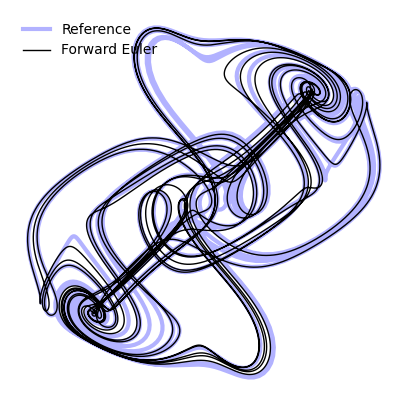

In [6]:
integrator = Euler(dt=0.0001)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3, label="Reference")
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k', label="Forward Euler")
plt.legend(frameon=False)
plt.axis('off')

### Questions

1. How does the Euler method fail at large step sizes? Try varying the step size and see how it affects the accuracy of the method.

2. How do you think these errors would change if we instead simulate a system that goes to a fixed point? Or a system with periodic oscillations?

<br><br><br><br><br><br>

# Runge-Kutta Methods

Runge-Kutta methods require more evaluations of the right hand side function $\mathbf{f}$ to compute each timestep, but have greater stability and accuracy. This entire family of methods is thus parametrized by the total number of evaluations of $\mathbf{f}$, the points at which these evaluations are made, and the weights used to combine the evaluations.

### The Modifed Euler method

The Modified Euler method is a specific second-order Runge-Kutta method. It is more computationally expensive than the Euler method, but it is also more accurate.

$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

We can see that this requires two evaluations of the right hand side function per timestep. The first evaluation is the same as the Euler method, but it is performed at the starting step $t_n$. The second evaluation is performed at the half-way point $t_{n+1/2} = t_n + \Delta t/2$.

In [7]:

class ModifiedEuler(BaseFixedStepIntegrator):
    """
    The modified Euler method is a second-order method, so it is more accurate than the 
    Euler method.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        # y + self.dt * f(t, y)
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        return y + self.dt * k2

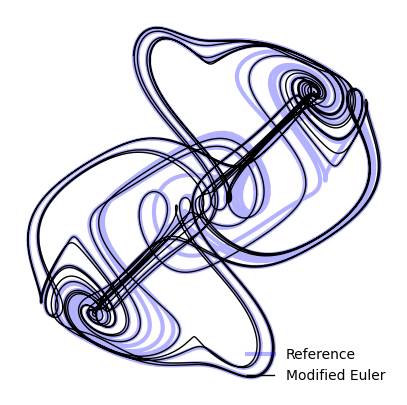

In [8]:
integrator = ModifiedEuler(dt=0.001)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3, label="Reference")
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k', label="Modified Euler")
plt.legend(frameon=False)
plt.axis('off');

### Tabular Runge-Kutta methods

We can re-write the modified Euler method,

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

As a series of the intermediate evaluations of the right hand side function,

$$
k_1 = \mathbf{f}(t_n, \mathbf{x}_n)
$$
$$
k_2 = \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2}k_1 )
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; k_2
$$

Notice how each step depends on intermediate calculations performed in the previous steps. There are many other Runge-Kutta methods that generalize this idea.



**Heun's method (RK2(3))** corresponds to a forward/explicit variant of the trapezoidal rule

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

This method requires two evaluations of the right hand side function per timestep. The first evaluation is the same as the forward Euler method, but it is used only to generate an approximate solution $\tilde{\mathbf{x}}_{n+1}$ at the end of the timestep. The next evaluation uses this approximate solution to generate a better estimate of the solution. The overall step is the average of the two evaluations.

In [9]:
class Heun(BaseFixedStepIntegrator):
    """
    The Heun method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt, y + self.dt * k1)
        return y + self.dt * (k1 + k2) / 2

**Ralston's method (RK3(4))** is a third-order method that is more accurate than Heun's method

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$

In [10]:
class Ralston(BaseFixedStepIntegrator):
    """
    The Ralston method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        return y + self.dt * k2






**Fourth-order Runge-Kutta or RK4(5)** is the default solver in many older languages (though Dormand-Prince, an adaptive step-size method, is more common in modern languages).

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
\end{align}
$$



In [11]:

class RK4(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 4 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        k3 = f(t + self.dt / 2, y + self.dt * k2 / 2)
        k4 = f(t + self.dt, y + self.dt * k3)
        return y + self.dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6



We can take this idea even futher, defining Runge-Kutta methods of arbitrary order.

In [12]:

class RK7(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 10 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 5, y + self.dt * k1 / 5)
        k3 = f(t + self.dt * 3 / 10, y + self.dt * (3 * k1 / 40 + 9 * k2 / 40))
        k4 = f(t + self.dt * 4 / 5, y + self.dt * (44 * k1 / 45 - 56 * k2 / 15 + 32 * k3 / 9))
        k5 = f(t + self.dt * 8 / 9, y + self.dt * (19372 * k1 / 6561 - 25360 * k2 / 2187 + 64448 * k3 / 6561 - 212 * k4 / 729))
        k6 = f(t + self.dt, y + self.dt * (9017 * k1 / 3168 - 355 * k2 / 33 + 46732 * k3 / 5247 + 49 * k4 / 176 - 5103 * k5 / 18656))
        k7 = f(t + self.dt, y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84))
        return y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84)

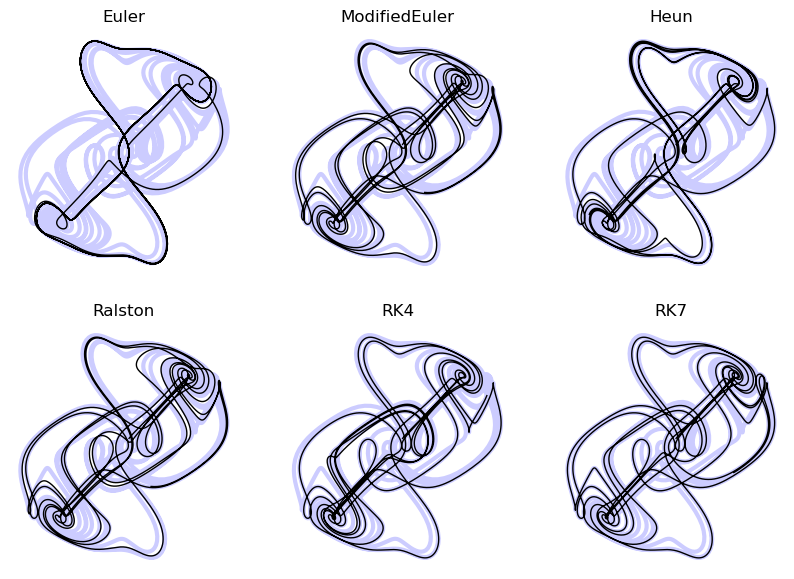

In [13]:
# dt_val = 0.5
dt_val = 0.1
system = thomas_model 
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)

plt.figure(figsize=(10, 7))

all_solutions = dict()
all_solutions["Reference"] = X_reference # store the solution for each integrator in a dictionary
for i, integrator in enumerate([Euler(), ModifiedEuler(), Heun(), Ralston(), RK4(), RK7()]):
    integrator.dt = dt_val
    sol = integrator.integrate(system, [t[0], t[-1]], ic, t_eval=t)
    all_solutions[integrator.name] = sol.y 

    plt.subplot(2, 3, i+1)
    plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.2)
    plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color="k")
    plt.title(integrator.name)
    plt.axis('off')


## The Butcher Tableau

The Butcher Tableau is a table that summarizes the evaluations used in a Runge-Kutta method. It is a recursive set of definitions for the coefficients in explicit Runge-Kutta methods.

In a generic Runge-Kutta methods, a given call to the right hand side function $\mathbf{f}$ is used to generate a series of intermediate values, which we denote,

$$
    k_{ni} = \mathbf{f}\left(t_n + c_i \Delta t,\;\; \mathbf{x}_n + \Delta t \sum_{j=1}^s a_{ij} k_{nj}\right)
$$

Notice that $k_{nj}$ appears in the definition of $k_{ni}$ for all $i \geq j$. Thus, as we increase $i$, we must compute more and more of the previous $k_{nj}$ terms.

The Butcher tableau is a table that summarizes the coefficients of the method

$$
\begin{array} {c|ccccc} 0\\ c_2 & a_{21}\\ c_3 & a_{31} & a_{32} \\ \vdots & \vdots & & \ddots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s-1}\\ \hline & b_1 & b_2 & \cdots & b_{s-1} & b_s \end{array}
$$

We read the Butcher Tableau from bottom to top, starting with the final step, and then going up the table to see how each step is constructed from the previous steps. However, computationally, we traverse the table from top to bottom. The all-zero row always corresponds to the forward Euler step ($c_1 = 0$), which serves as a base case for the recursion.

Each column of the tableau tells us how much to weight the output of the corresponding previous row when computing that row.

<br><br><br><br><br><br>


#### The forward Euler method

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$

\begin{array} 
{c|c} 0 & 0\\ \hline & 1
\end{array}

The one in the bottom right tells us that the final step is exactly equal to $1\times$ the single evaluation used in the first row.

<!-- #### Euler's method (backward step)

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

\begin{array} 
{c|c} 1 & 1\\ \hline & 1
\end{array} -->

#### Modified Euler's method

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

\begin{array}
{c|cc} 0 & 0 & 0\\ \frac{1}{2} & \frac{1}{2} & 0\\ \hline & 0 & 1
\end{array}

Since this requires two evaluations of the right hand side function per timestep, we perform one evaluation to populate the base case (first row) at the top. We then populate the second row from the top by evaluating the right hand side function at the half-way point $t_{n+1/2} = t_n + \Delta t/2$, and we use a state value equal to the original state plus half the step size times the first evaluation.


#### Heun's method

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

\begin{array}
    {c|cc} 0 & 0 & 0\\ 1 & 1 & 0\\ \hline & 1/2 & 1/2
\end{array}

#### Ralston's method


$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$

\begin{array}
{c|ccc} 0 & 0 & 0 & 0\\ 1/4 & 1/4 & 0 & 0\\ 3/4 & 0 & 3/4 & 0\\ \hline & 2/9 & 3/9 & 4/9
\end{array}

#### Runge-Kutta 4th order (RK4)

This is the most common fixed-step Runge-Kutta method,

$$
    \begin{align}
    k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
    k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
    k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
    k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
    \mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
    \end{align}
$$


\begin{array}
{c|cccc} 0 & 0 & 0 & 0 & 0\\ 1/2 & 1/2 & 0 & 0 & 0\\ 1/2 & 0 & 1/2 & 0 & 0\\ 1 & 0 & 0 & 1 & 0\\ \hline & 1/6 & 1/3 & 1/3 & 1/6
\end{array}

<!-- 
\begin{bmatrix}
0 & 0 & 0 & 0 & 0\\ 
1/2 & 1/2 & 0 & 0 & 0\\ 
1/2 & 0 & 1/2 & 0 & 0\\ 
1 & 0 & 0 & 1 & 0\\ 
\hline & 1/6 & 1/3 & 1/3 & 1/6
\end{bmatrix} -->



<!-- \begin{array} {c|ccccc} c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ \vdots & \vdots & & \ddots & \vdots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s}\\ \hline & b_1 & b_2 & \cdots & b_{s} \end{array}


Notes here:
https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/ -->

### Convergence and stability of ODE solvers: various definitions of error

The *global error* of a solver at a given step is given by
$$
    e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. 

The *truncation error* for a fixed-step solver with step size $\Delta t$ is
$$
    T_n = \frac{\mathbf{x}_{n+1} - \mathbf{x_n}}{\Delta t} - \mathbf{f}(t_n, \mathbf{X}(t_{n}))
$$
Where we've applied the right hand side of the ODE to the *exact* solution to get the exact derivative at that time step. Notice that this quantity is a property of our solver.

The *local error* is therefore given by
$$
    \ell_n = \Delta t \; ||T_n||
$$

This measures the error introduced during a single timestep, under a linear approximation of the ODE. 

We can use our reference trajectory to estimate the local and global error of several of our solvers.



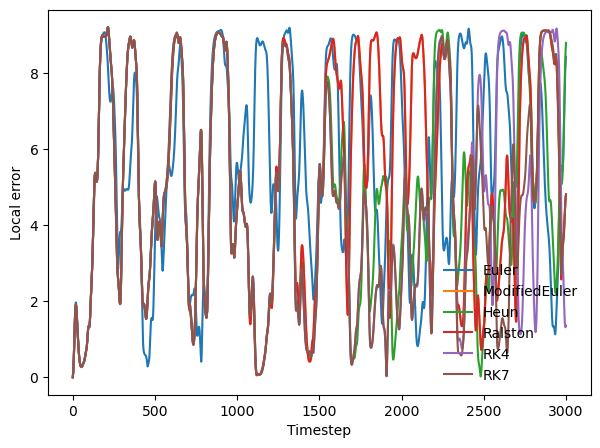

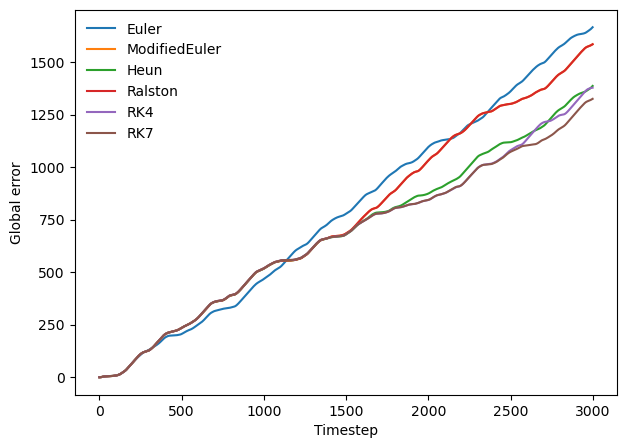

In [14]:
all_global_errors = dict()
all_local_errors = dict()
for i, integrator in enumerate([Euler(), ModifiedEuler(), Heun(), Ralston(), RK4(), RK7()]):
    traj_true = all_solutions["Reference"]
    traj_approx = all_solutions[integrator.name]
    local_error = np.linalg.norm(traj_true - traj_approx, axis=1)
    global_error = np.cumsum(local_error) * dt_val
    
    all_local_errors[integrator.name] = local_error
    all_global_errors[integrator.name] = global_error

plt.figure(figsize=(7, 5))
for item in all_local_errors:
    plt.plot(all_local_errors[item], label=item)
plt.xlabel("Timestep")
plt.ylabel("Local error")
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(7, 5))
for item in all_global_errors:
    plt.plot(all_global_errors[item], label=item)
plt.xlabel("Timestep")
plt.ylabel("Global error")
plt.legend(frameon=False)
plt.show()







## Global error accumulates from local error

The global error is given by
$$
e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. The global error at the next step is given by
$$
e_{n+1} = || \mathbf{x}_{n+1} - \mathbf{X}(t_{n+1})||
$$

We can use the Taylor series expansion of the exact solution, and of the numerical solution, to write
$$
\mathbf{X}(t_{n+1}) = \mathbf{X}(t_{n}) + \Delta t \mathbf{X}'(t_{n}) + \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) + \cdots
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} ≈'(t_n, \mathbf{x}_n) + \cdots
$$

where $\mathbf{X}' \equiv \mathbf{f}(\mathbf{X})$. Substituting both expansions into the global error at the next step, we get

$$
e_{n+1} = || \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} \mathbf{f}'(t_n, \mathbf{x}_n) + \cdots - \mathbf{X}(t_{n}) - \Delta t \mathbf{X}'(t_{n}) - \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) - \cdots||
$$

Rearranging terms,

$$
e_{n+1} = || \bigg(\mathbf{x}_{n} - \mathbf{X}(t_{n})\bigg) + \Delta t \bigg(\mathbf{f}(t_n, \mathbf{x}_n) - \mathbf{X}'(t_{n})\bigg) + \frac{\Delta t^2}{2} \bigg( \mathbf{f}'(t_n, \mathbf{x}_n) - \mathbf{X}''(t_{n})\bigg) + \cdots ||
$$

<br><br><br><br><br><br>

Now, let's assume that $\mathbf{f}$ satisfies a Lipshitz condition, which means that the derivative of $\mathbf{f}$ is Lipschitz continuous with respect to the solution. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$ in terms of the solution. Then we can write

$$
|\mathbf{f}(t, u) - \mathbf{f}(t, v)| \leq L ||u - v|| |
$$

Where $L$ is a constant called the Lipshitz constant. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$. If we have a simple right hand side, then we can calculate the Lipshitz constant as the maximum of the gradient on the domain of the problem, for all values of $t$. However, even non-differentiable functions can satisfy a Lipshitz condition.

Hence,
$$
|e_{n+1}| \leq |e_{n}| + \Delta t L_f |e_n| + \Delta t |T_k|
$$

$$
|e_{n+1}| \leq |e_{n}| (1 + \Delta t L_f) + \Delta t |T_k|
$$

Where the truncation error term captures the higher-order terms in our grouped series expansion above. This expression therefore relates the rate of growth in the global error $|e_{n}|$ to the Lipschitz constant of our problem $L$, and the properties of our solving method $T$.

Let's recap what we just learned: A problem has an intrinsic difficulty set by the Lipschitz constant $L$, and but we can change $\Delta t$ and $T_k$ to control the global error growth rate. If we need a given $\Delta t$ to to limits on the number of timesteps we can simulate, we can choose the order of the method $T_k$ to control the local error. Likewise, if we need to limit the order of our method due to memory or overhead limits, we can choose a smaller $\Delta t$ to control the global error growth rate. We can thus see that there is an implicit trade-off between accuracy and computational cost.


## Implicit Integration

Recall that the forward Euler method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n)
$$

Implicit integration method like the "backward" Euler method attempt to solve ODE using iterations of the form

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

Because $\mathbf{x}_{n+1}$ appears on both sides of the equation, we need to solve for it. This is therefore a nonlinear equation in $\mathbf{x}_{n+1}$ that we need to solve *in each step*.


### The Butcher tableau for implicit methods

The forward Euler method had a Butcher tableau of the form

$$
    \begin{array}{c|c}
    0 & 0 \\
    \hline
    & 1
    \end{array}
$$
The tableau this had a lower-triangular form, with all the coefficients above the main diagonal equal to zero. This means that each element in a given row can only depend on elements at earlier rows.

The backward Euler method instead has a Butcher tableau of the form
$$
\begin{array}{c|c}
1 & 1 \\
\hline
 & 1
\end{array}
$$

Generally speaking, Butcher tableau for implicit methods have non-zero entries above the main diagonal. This implies that the an element in a given row can depend on an element at a later row, resulting in a circular dependency that requires a nonlinear solver.

<br><br><br><br><br><br><br><br>


### The Backwards Euler method

The backwards Euler method has the form
$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

unlike the forward Euler method, the gradient term depends on the unknown value of the state **at a future timestep**. We move the unknown $\mathbf{x}_{n+1}$ to the same side,
$$
    0 = \mathbf{x}_{n} - \mathbf{x}_{n+1} + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

We define the unknown as an auxiliary variable $\mathbf{u} = \mathbf{x}_{n+1}$, and we write this equality as the minimization of function $\mathbf{g}$
$$
    \mathbf{g}(\mathbf{u}) \equiv \mathbf{u} - \mathbf{x}_n - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{u})
$$

We want to minimize this function in order to determine $\mathbf{x}_{n+1}$. Taking the gradient of $\mathbf{g}$ with respect to $\mathbf{u}$, we get

$$
    \frac{\partial \mathbf{g}}{\partial \mathbf{u}} = \mathbf{I} - \Delta t\; \frac{\partial \mathbf{f}}{\partial \mathbf{u}}
$$

The matrix $J(\mathbf{u}) \in \mathbb{R}^{N \times N}$ is the Jacobian of $\mathbf{f}$ evaluated at $\mathbf{u}$,

$$
    J(\mathbf{u}) \equiv \frac{\partial \mathbf{f}}{\partial \mathbf{u}}
$$

We can therefore optimize in $\mathbf{u}$ using a matrix inverse,

$$
    \mathbf{u}_{n+1} = \mathbf{u}_n - \left(\mathbf{I} - \Delta t\; J(\mathbf{u})\right)^{-1}\mathbf{g}(\mathbf{u}_n)
$$

After we complete our optimization, we set $\mathbf{x}_{n+1} = \mathbf{u}_{n+1}$ and then move to the next timestep.

<br><br><br><br><br><br><br><br>

<!-- We take the gradient with respect to $\mathbf{x}_{n+1}$ to get

$$
\frac{\partial \mathbf{x}_n}{\partial \mathbf{x}_{n+1}} = \mathbf{I} - \Delta t\; J(t_{n+1}, \mathbf{x}_{n+1})
$$

where $\mathbf{I}$ is the identity matrix and $J$ is the Jacobian of $\mathbf{f}$ evaluated at $\mathbf{x}_{n+1}$. We can therefore solve for $\mathbf{x}_{n+1}$ by approximating this solution with the Newton-Raphson method: -->


In order to implement this method, we need to add an analytic Jacobian to our system of equations. We can do this analytically for the Thomas model by taking the univariate derivative of each ODE $\dot{x}, \dot{y}, \dot{z}$ with respect to each variable $x, y, z$.

In [15]:
class ThomasModelWithJacobian(ThomasModel):
        
    def jac(self, t, X):
        x, y, z = X
        J = np.array([
            [-self.b, np.cos(y), 0],
            [0, -self.b, np.cos(z)],
            [np.cos(x), 0, -self.b]
        ])
        return J

thomas_model = ThomasModelWithJacobian()

We can now implement the implicit Euler method by adding a `newton` method to our base class. This method will use Newton's method to minimize the function $\mathbf{g}$ with respect to $\mathbf{u}$ using the Jacobian $J(\mathbf{u})$, and then set $\mathbf{x}_{n+1} = \mathbf{u}_{n+1}$. This requires inverting the Jacobian matrix, which is not too expensive here because $N = 3$.

In [16]:
class ImplicitEuler(BaseFixedStepIntegrator):
    """
    The implicit Euler method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def newton(self, f, jac, t, y, tol=1e-6, max_iter=30):
        """
        Newton's method for solving nonlinear equations.

        Args:
            f: The right-hand side function of the ODE. Returns a vector of length $N$.
            jac: The Jacobian of the right-hand side function. Returns a matrix of 
                size $N \times N$.
            t: The current time.
            y: The current state.
            tol: The tolerance for the solution.
            max_iter: The maximum number of iterations.

        Returns:
            The solution to the nonlinear equation.
        """
        y0 = y.copy()
        n = len(y)
        for i in range(max_iter):
            g = y - y0 - self.dt * f(t, y)
            dg = np.identity(n) - self.dt * jac(t, y)
            #dy = np.linalg.solve(dg, g) # slightly faster than 
            dy = np.linalg.inv(dg) @ g
            y -= dy
            if np.linalg.norm(dy) < tol:
                break
        return y
    
    def update(self, f, t, y):
        return self.newton(f, f.jac, t, y)


        


0.1
0.1


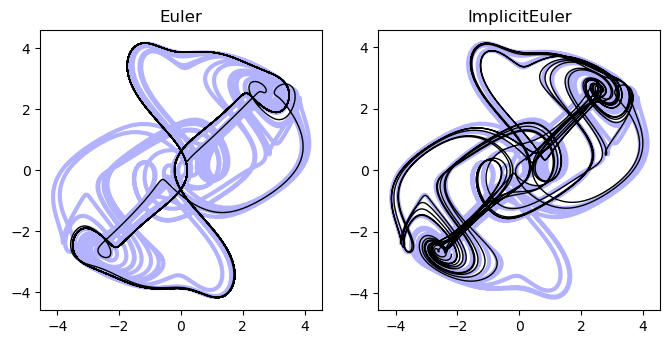

In [17]:
dt_val = 0.1
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


plt.figure(figsize=(8, 8))

# explicit methods
integrator = Euler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 2, 1)
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.title(integrator.name)
print(integrator.dt)

# implicit methods
integrator = ImplicitEuler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 2, 2)
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.title(integrator.name)
print(integrator.dt)


## Why use implicit methods?

Because we have to invert a matrix, each step is more expensive than the explicit Euler method, but the method is more accurate. As a result, in exchange for paying the $N \times N$ cost of inverting the Jacobian matrix, we can get away with using a larger time step. So performing an integration comes down to our tolerance for accumulating error over timesteps, versus our ability to invert large matrices. For some classes of systems, such as sparsely-coupled systems like PDE, the Jacobian is sparse, and so the cost of inverting the matrix is can be reduce.

We can mathematically do the same thing we just did for Euler in order to implement implicit Runge-Kutta and other methods, but the math gets more complicated due to all the recursive definitions. A very common method used with `scipy.integrate.solve_ivp` is the *Radau* method, which is a higher-order implicit Runge-Kutta method.

<br><br><br><br><br><br><br><br>

## Multistep methods

Often, we encounter "stiff" equations, for which $\mathbf{f}$ is very sensitive to small changes in $\mathbf{x}$. This results in a large Lipshitz constant $L$ on a non-trivial portion of the solution domain. In cases like this, we have to pick extremely small $\Delta t \sim 1/L$ to get a stable solution. Mechanistically, stiff systems result from well-separated timescales, all of which need to be resolved. Chaotic systems are often stiff.

The idea behind *multistep methods* is to combine past steps to get a better estimate of the current step. Common methods are Adams-Bashforth and Adams-Moulton, as well as BDF (backward differentiation formula). The latter is a workhorse method for stiff ODEs that is included in SciPy's `solve_ivp` function. Multistep methods are reministicent of "momentum" in optimization, in which we use memory of past updates to inform the current one.


Our Runge-Kutta methods have the form:

$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \sum_{i=1}^s b_i \mathbf{k}_i
$$
where $\mathbf{k}_i$ are the slopes at the intermediate points. We can generalize this to multistep methods by composing our first step as well.

A linear multistep is a linear combination of past steps, plus a weighted sum of the right-hand side evaluated at past steps.
$$
\mathbf{x}_{n+1} = \sum _{i=0}^{s} a_{i} \mathbf{x}_{n-i} + \Delta t \sum _{j=-1}^{s}b_{j}\mathbf{f}\left(t_{n-j},\mathbf{x}_{n-j}\right).
$$
where $s$ is the order of the method. For example, the Adams-Bashforth method has coefficients $a_i = 0$ for $i > 0$ and $b_j = 1$ for $j \geq 0$. The second order Adams-Bashforth method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {3}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})-{\tfrac {1}{2}}\mathbf{f}(t_{n-1}, \mathbf{x}_{n-1})\bigg)
$$


In [18]:
class AdamsBashforth:
    """
    The Adams-Bashforth method for integration
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y):
        """
        Integrate the system using the Adams-Bashforth method

        """
        self.t = np.arange(tspan[0], tspan[-1], self.dt)
        self.y = np.zeros((len(self.t), len(y)))
        self.y[0] = y
        self.y[1] = self.y[0] + self.dt * f(self.t[0], self.y[0])
        for i, t in enumerate(self.t):
            if i < 2:
                continue
            self.y[i] = self.y[i - 1] + self.dt * (3/2 * f(t, self.y[i-1]) - 1/2 * f(t, self.y[i-2]))
        return self

(np.float64(-4.5623945389624785),
 np.float64(4.5682038154685385),
 np.float64(-4.564564347026234),
 np.float64(4.560749073030232))

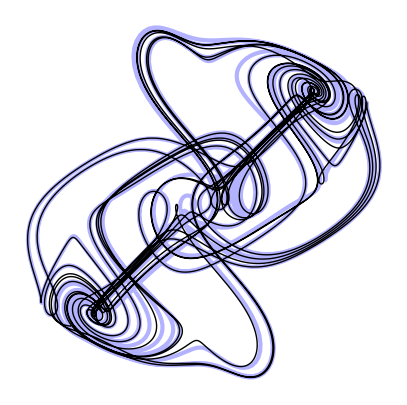

In [19]:
dt_val = 0.001
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


integrator = AdamsBashforth(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
# plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
# plt.title(integrator.name)
# print(integrator.dt)


plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off')

The second-order Adams-Moulton method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {1}{2}}\mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})+{\tfrac {1}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})\bigg)
$$

Notice that this method has an implicit definition. This implicit equation represents the *trapezoidal rule*

## Predictor-Corrector methods

Predictor-corrector methods are a generalization of the multistep methods to use future estimated terms, rather than just past terms. The idea is to use a multistep method to predict the next step, and then use a single step method to correct the prediction. The multistep method is called the *predictor*, and the single step method is called the *corrector*.

For example, instead of solving the implicit equation for the Adams-Moulton method, we can use the explicit Euler method to correct the prediction. This is called the *Adams-Bashforth-Moulton* method. The general form is

$$
    \tilde{\mathbf{x}}_{n+1} = \mathbf{x}_{n} + \Delta t\; \mathbf{f}(t_{n}, \tilde{\mathbf{x}}_{n})
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {1}{2}}\mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})+{\tfrac {1}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})\bigg)
$$



In [20]:
class AMPredictorCorrector:
    """
    The Adams-Moulton method for integration with predictor-corrector updates
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y):
        """
        Integrate the system using the Adams-Moulton method

        """
        self.t = np.arange(tspan[0], tspan[-1], self.dt)
        self.y = np.zeros((len(self.t), len(y)))
        self.y[0] = y
        for i, t in enumerate(self.t):
            if i < 1:
                continue
            # predictor-corrector
            ytilde = y + self.dt * f(t, y)
            y = y + self.dt * 0.5 * (f(t, y) + f(t, ytilde))
            self.y[i] = y.copy()
        return self

    

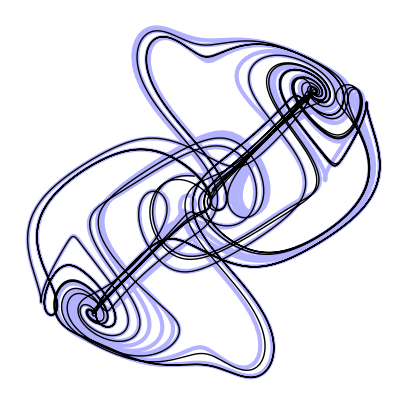

In [21]:
dt_val = 0.001
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


integrator = AMPredictorCorrector(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)

plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off');

## A numerical integration bakeoff

We have seen that there are many different methods for integrating ODEs. Let's see how they perform for the Thomas system. For each system, we will compute the mean-squared error of the final solution compared to our high-fidelity reference trajectory. We will also compute the runtime of each method.

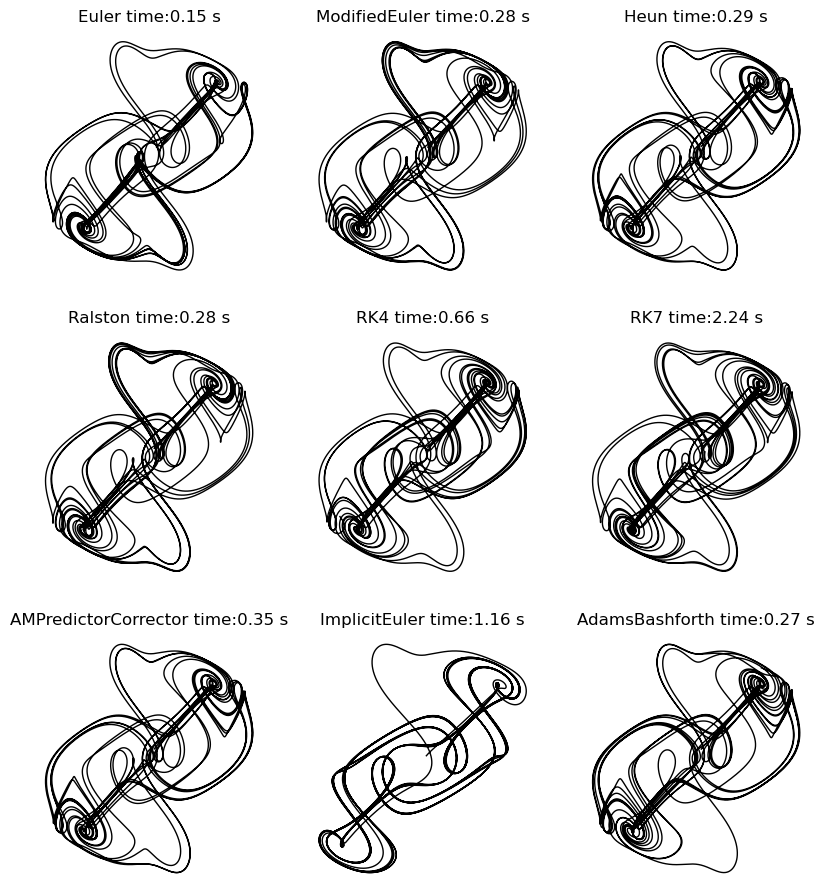

In [22]:
dt_val = 0.01
# dt_val = 0.5
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model



## A helpful function for computing the error of a method
def interp1d_axis(x, xp, fp, axis=-1):
    """
    Interpolate an array in one dimension along a specified axis
    
    Args:
        x (list or np.ndarray): 
        xp (list or np.ndarray): 
        xp (list or np.ndarray): 
    
    """
    y_resample = list()
    for i in range(fp.shape[axis]):
        y_resample.append(
            np.interp(x, xp, fp[:, i])
        )
    y_resample = np.array(y_resample).T
    return y_resample

integrators = [
    Euler(),
    ModifiedEuler(),
    Heun(),
    Ralston(),
    RK4(),
    RK7(),
    AMPredictorCorrector(),
    ImplicitEuler(),
    AdamsBashforth(),
]

import time

all_results = dict() # an object to store our bakeoff results
plt.figure(figsize=(10, 15))
for i, integrator in enumerate(integrators):
    integrator.dt = dt_val

    t0 = time.time()
    sol = integrator.integrate(system, [t[0], t[-1]], ic)
    t1 = time.time()
    runtime = t1 - t0


    ## Compute the Mean-squared error compared to the high-fidelity reference trajectory 
    ## we found above. Because we are using a different integration timestep, we 
    ## downsample our solutions to match the reference
    y_resample = interp1d_axis(t_reference, sol.t, sol.y)
    err = np.mean(np.sum((X_reference - y_resample)**2, axis=-1))

    integrator_name = type(integrator).__name__
    all_results[integrator_name] = dict()
    all_results[integrator_name]["time"] = runtime
    all_results[integrator_name]["error"] = err
    
    plt.subplot(4, 3, i + 1)
    plt.plot(sol.y[:, 0], sol.y[:, 1], 'k', linewidth=1)
    plt.title(integrator.name + " time:" + str(round(runtime, 2)) + " s")
    plt.axis("off")

plt.show()



    


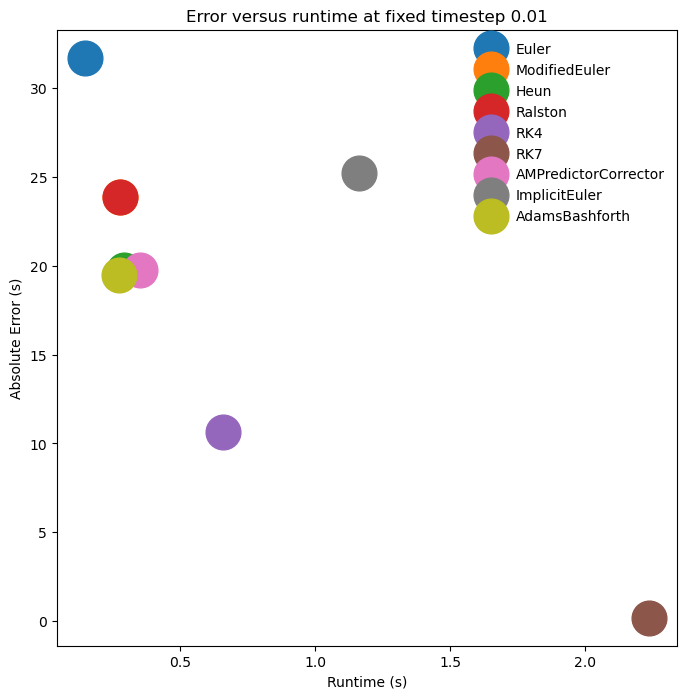

In [23]:
plt.figure(figsize=(8, 8))
for integrator_name in all_results.keys():
    plt.plot(
        all_results[integrator_name]["time"],
        all_results[integrator_name]["error"],
        ".",
        label=integrator_name,
        markersize=50
    )
plt.xlabel("Runtime (s)")
plt.ylabel("Absolute Error (s)")
plt.title(f"Error versus runtime at fixed timestep {dt_val}")
plt.legend(framealpha=0.0)

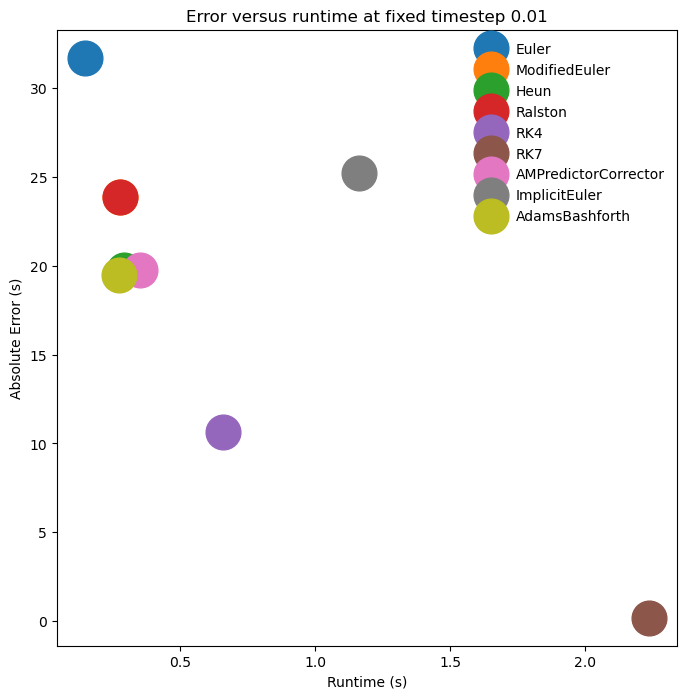

In [24]:
plt.figure(figsize=(8, 8))
for integrator_name in all_results.keys():
    plt.plot(
        all_results[integrator_name]["time"],
        all_results[integrator_name]["error"],
        ".",
        label=integrator_name,
        markersize=50
    )
plt.xlabel("Runtime (s)")
plt.ylabel("Absolute Error (s)")
plt.title(f"Error versus runtime at fixed timestep {dt_val}")
plt.legend(framealpha=0.0)

### The Lorenz system

The Thomas model is one example of a set of coupled ODEs that exhibit chaotic behavior. The Lorenz system is another famous example of a set of ODEs that exhibit chaotic behavior. It is given by:

$$
\begin{align}
    \dot{x} &= \sigma (y - x) \\
    \dot{y} &= x (\rho - z) - y \\
    \dot{z} &= x y - \beta z
\end{align}
$$

This model was first studied by [Edward Lorenz, Ellen Fetter, and Margaret Hamilton in the 1960s](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2), and is a simplified model of atmospheric convection. It is one of the first dissipative systems for which sustained chaotic behavior was found, partly with the help of early computers.

(np.float64(-20.902256501629225),
 np.float64(21.471064289785556),
 np.float64(-28.61074427154573),
 np.float64(29.939403081845946))

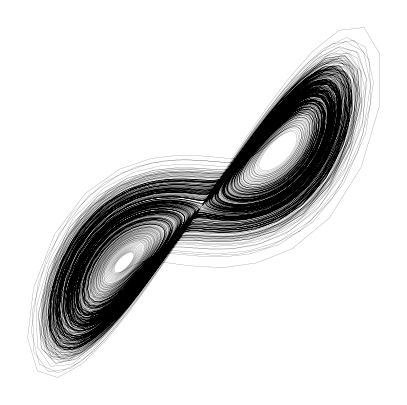

In [25]:
class LorenzModel:

    def __init__(self, sigma=10, rho=28, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def __call__(self, t, X):
        return self.rhs(t, X)

    def rhs(self, t, X):
        """
        Lorenz dynamical model
        """
        x, y, z = X
        xdot = self.sigma * (y - x)
        ydot = x * (self.rho - z) - y
        zdot = x * y - self.beta * z
        return np.array([xdot, ydot, zdot])

lorenz_model = LorenzModel()

# We integrate the ODE using scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 500, 20000)
sol = solve_ivp(lorenz_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)
plt.axis('off')

(np.float64(-20.219986887766247),
 np.float64(21.409175679565532),
 np.float64(-27.387177515918737),
 np.float64(29.847909942782024))

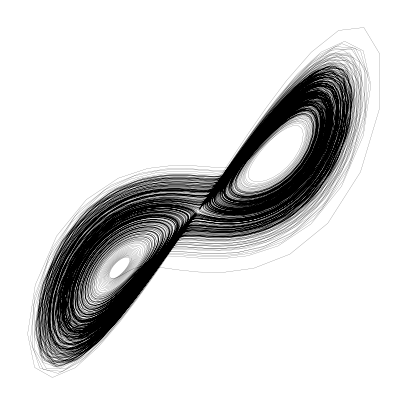

In [26]:

class LorenzModelWithJacobian(LorenzModel):

    def jac(self, t, X):
        x, y, z = X
        J = np.array([
            [-self.sigma, self.sigma, 0],
            [self.rho - z, -1, -x],
            [y, x, -self.beta]
        ])
        return J
lorenz_model = LorenzModelWithJacobian()

# We integrate the ODE using scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 500, 20000)
sol = solve_ivp(lorenz_model, [t[0], t[-1]], ic, t_eval=t, method='Radau', jac=lorenz_model.jac)
X = sol.y.T


plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)
plt.axis('off')